# Analysis of US Coastguard GPS disruption data

## Prerequisites

In [1]:
import pandas as pd
from datetime import datetime as dt

In [4]:
%pip install lxml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 50.1 MB/s eta 0:00:00:00:0100:01

[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Webscrape
Run this to webscrape the data to file. If you already have the data locally, skip the following cell

### Web scrape GPS interruptions

In [2]:
table_list = pd.read_html(r'https://navcen.uscg.gov/gps-problem-report-status')
table_list[0].to_csv('gps_navcen.csv',index=False)

### Web scrape wikipedia US state codes

In [57]:
table_list_iso3166= pd.read_html('https://en.wikipedia.org/wiki/ISO_3166-2:US')

In [58]:
two_letter_codes=table_list_iso3166[0]
two_letter_codes['clean_state']=two_letter_codes['Code'].apply(lambda x: x.split('-')[1])
two_letter_codes.to_csv('US_states_iso3166.csv',index=False)

## Processing and Analysis

In [2]:
gps_disruption_df=pd.read_csv('gps_navcen.csv')
US_states_iso3166=pd.read_csv('US_states_iso3166.csv')
#US_states_iso3166[57]=['UK-UK','United Kingdom','Country','UK']

In [3]:
gps_disruption_df.head()

,Disruption Date/Time,Location,Type,Description,Cause,Closed Date
0,10/16/2022 14:13:00 CST,Independence,Automobile,USER: My mapping services are constantly searc...,Mapping Issue,10/25/2022
1,10/06/2022 09:15:00 CST,"Dallas, TX by Southern Methodist University",Other,"USER: For several years now, on and off throug...",Insufficient Information,10/25/2022
2,09/17/2022 13:00:00 EST,"Navy Yard, Washington DC",None,USER: Our car navigation system and our mobile...,Insufficient Information,10/25/2022
3,09/10/2022 09:45:00 CST,Chicago,Automobile,USER: Both my standalone gps and phone gps rep...,Insufficient Information,10/25/2022
4,09/07/2022 13:15:00 EST,"I-20 near Columbia, SC",Automobile,"USER: Several times, most recently yesterday, ...",Mapping Issue,09/13/2022


## Analyse disruptions by date

In [4]:
gps_disruption_df['local_date']=gps_disruption_df['Disruption Date/Time']\
.apply(lambda x:dt.strptime(x[0:10],'%m/%d/%Y'))

<AxesSubplot: xlabel='local_date'>

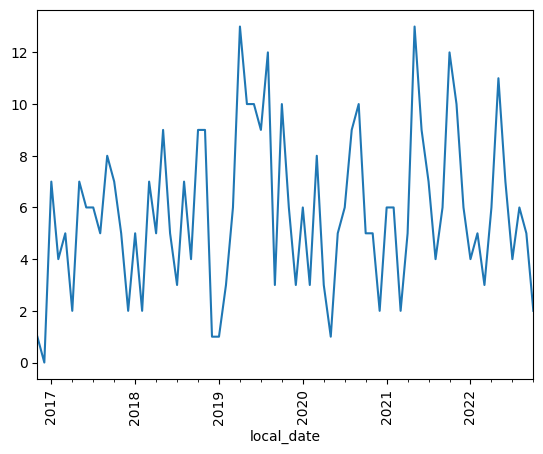

In [5]:
gps_disruption_df.resample('M', on='local_date').\
count()['Disruption Date/Time'].plot(rot=90)


## Analyse disruptions by location

In [6]:
gps_disruption_df['location_clean']=gps_disruption_df['Location'].\
apply(lambda x:x.split(',')[-1].strip().upper())
gps_disruption_df['location_clean_group_len']=gps_disruption_df['location_clean']\
.apply(lambda x: len(x))
gps_disruption_df['location_clean2']=gps_disruption_df['location_clean']


In [7]:
gps_disruption_df

,Disruption Date/Time,Location,Type,Description,Cause,Closed Date,local_date,location_clean,location_clean_group_len,location_clean2
0,10/16/2022 14:13:00 CST,Independence,Automobile,USER: My mapping services are constantly searc...,Mapping Issue,10/25/2022,2022-10-16,INDEPENDENCE,12,INDEPENDENCE
1,10/06/2022 09:15:00 CST,"Dallas, TX by Southern Methodist University",Other,"USER: For several years now, on and off throug...",Insufficient Information,10/25/2022,2022-10-06,TX BY SOUTHERN METHODIST UNIVERSITY,35,TX BY SOUTHERN METHODIST UNIVERSITY
2,09/17/2022 13:00:00 EST,"Navy Yard, Washington DC",None,USER: Our car navigation system and our mobile...,Insufficient Information,10/25/2022,2022-09-17,WASHINGTON DC,13,WASHINGTON DC
3,09/10/2022 09:45:00 CST,Chicago,Automobile,USER: Both my standalone gps and phone gps rep...,Insufficient Information,10/25/2022,2022-09-10,CHICAGO,7,CHICAGO
4,09/07/2022 13:15:00 EST,"I-20 near Columbia, SC",Automobile,"USER: Several times, most recently yesterday, ...",Mapping Issue,09/13/2022,2022-09-07,SC,2,SC
...,...,...,...,...,...,...,...,...,...,...
414,01/05/2017 4:35 UTC,Chile,Law Enforcement,User: There were large spikes in geozone alarm...,User Equipment,05/20/2019,2017-01-05,CHILE,5,CHILE
415,01/03/2017 11:AM CST,San Angelo Airport,Aviation,User: The GPS systems in normal mode not milit...,Unintentional Interference,05/20/2019,2017-01-03,SAN ANGELO AIRPORT,18,SAN ANGELO AIRPORT
416,01/02/2017 3:00 EST,North Carolina - South Carolina border,Transportation,User: GPS would say when you plug in that ther...,User Equipment,05/20/2019,2017-01-02,NORTH CAROLINA - SOUTH CAROLINA BORDER,38,NORTH CAROLINA - SOUTH CAROLINA BORDER
417,01/01/2017 12:00 EST,"Elizabeth, NJ",Transportation,"User: My business is located in Elizabeth, NJ....",Mapping Issue,05/20/2019,2017-01-01,NJ,2,NJ


### Two letter codes, mostly US states

<AxesSubplot: ylabel='Subdivision name (en)'>

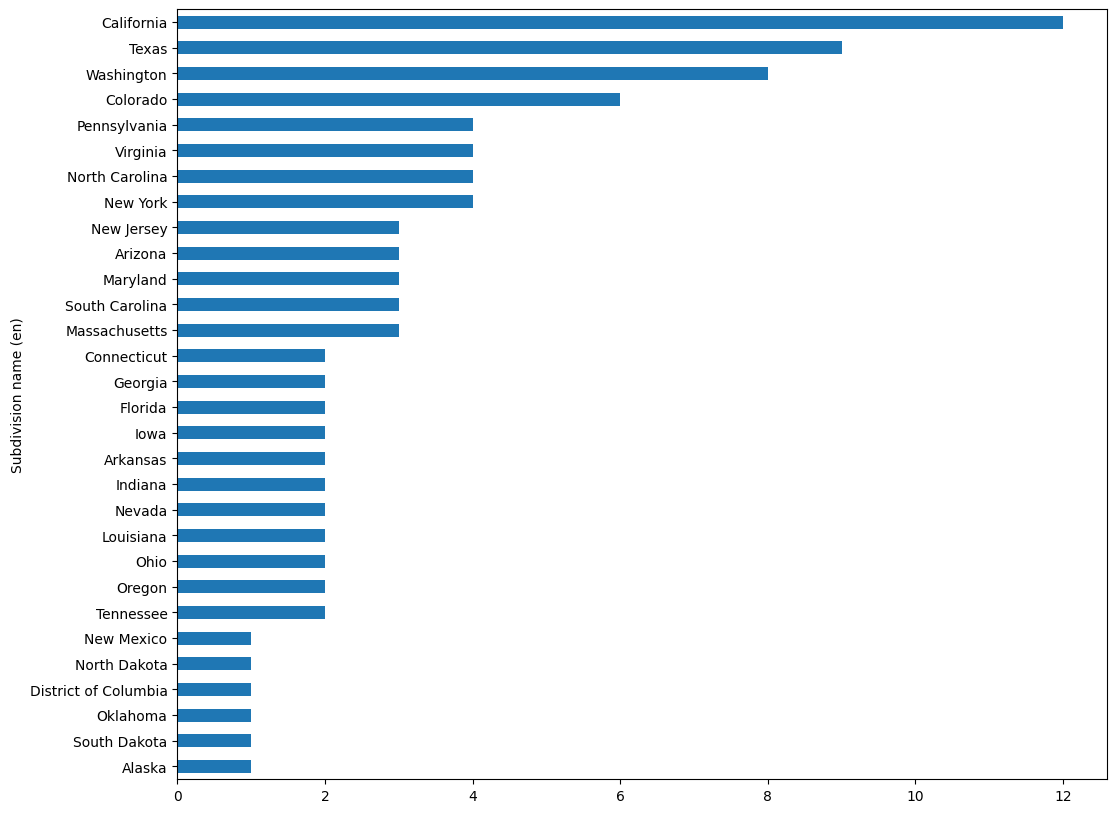

In [8]:
gps_disruption_df[gps_disruption_df['location_clean_group_len']==2].merge(US_states_iso3166,how='left',left_on='location_clean2',right_on='clean_state')\
.groupby('Subdivision name (en)').count()['Disruption Date/Time'].sort_values()\
.plot(kind='barh',figsize=[12,10])

In [13]:
subdivision_names=gps_disruption_df[gps_disruption_df['location_clean_group_len']==2].merge(US_states_iso3166,how='left',left_on='location_clean2',right_on='clean_state')\


subdivision_names[subdivision_names['Subdivision name (en)'].isna()]

,Disruption Date/Time,Location,Type,Description,Cause,Closed Date,local_date,location_clean,location_clean_group_len,location_clean2,Code,Subdivision name (en),Subdivision category,clean_state
10,08/18/2021 12:20:09 GMT,"Bedford, UK",Other,User: Vertical data lost accuracy. Reported al...,Unknown Interference,09/29/2021,2021-08-18,UK,2,UK,NaN,NaN,NaN,NaN
44,10/08/2018 07:40 UTC,"Huddersfield, UK",Communications,User: Loss of GPS lock for approx. 4 minutes d...,User Equipment,05/08/2019,2018-10-08,UK,2,UK,NaN,NaN,NaN,NaN
45,09/27/2018 1100 CET,"Plymouth, UK",Marine,User: The intermittent fault happened several ...,Unknown Interference,05/07/2019,2018-09-27,UK,2,UK,NaN,NaN,NaN,NaN


### Mostly countries, but needs cleaning

In [46]:
disruptions_by_location=gps_disruption_df[gps_disruption_df['location_clean_group_len']!=2].groupby('location_clean2').count()['Disruption Date/Time']


In [47]:
disruptions_by_location[disruptions_by_location>1].sort_values(ascending=False)#.plot(kind='barh')

location_clean2
EGYPT                     23
LIMASSOL                   9
ITALY                      6
CYPRUS                     6
BRAZIL                     5
FLORIDA                    4
GLOBAL                     4
LEBANON                    4
CHINA                      4
EAST OF MALTA              3
ISRAEL                     3
LIBYA                      3
GERMANY                    3
CALIFORNIA                 3
GREECE                     3
SPAIN                      3
SAUDI ARABIA               3
PRC                        2
ALABAMA                    2
NEW YORK                   2
SUEZ CANAL                 2
TEXAS                      2
TURKEY                     2
UNITED STATES              2
OREGON                     2
IRAN                       2
MEDITERRANEAN SEA          2
ISTANBUL                   2
ALASKA                     2
INDIA                      2
FINLAND                    2
EASTERN MEDITERRANEAN      2
EAST MEDITERRANEAN SEA     2
AT SEA                     

<AxesSubplot: ylabel='location_clean2'>

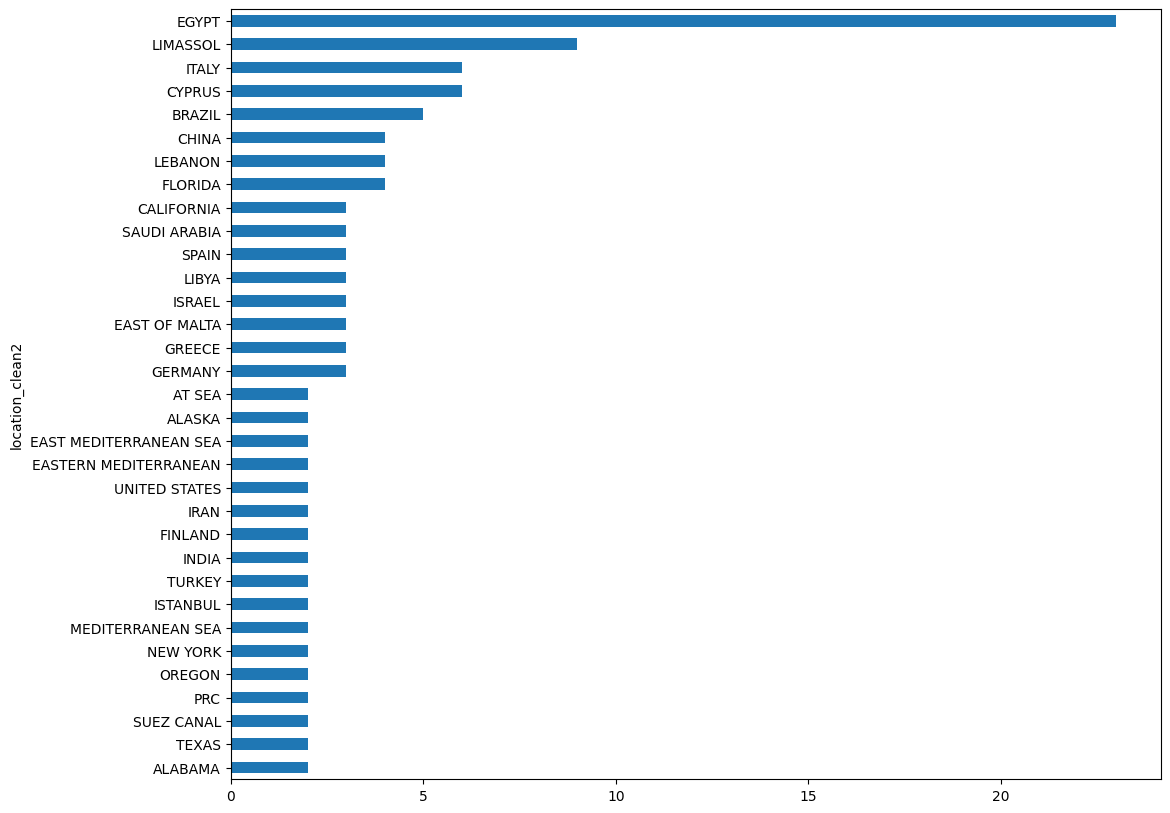

In [48]:
#def group_locations(string_x):
#    if string_x==''

disruptions_by_location[disruptions_by_location>1 ].drop(['WORLDWIDE','GLOBAL']).sort_values()\
.plot(kind='barh',figsize=[12,10])

In [49]:
gps_disruption_df.query('Location in ("Worldwide","Global","At sea")')[['local_date','Location','Description','Cause']]

,local_date,Location,Description,Cause
91,2021-07-28,At sea,USER: The vessel was sailing towards port said...,Unknown Interference
138,2021-01-16,Global,CNES has detected a repetition of IODE for PRN...,IODC_10-Bit
169,2020-08-04,Global,User: CNES (Centre National d Etudes Spatiales...,ICD_Violation
195,2020-02-12,Worldwide,"User: In February 2020 (Feb 12th, 13th, 15th a...",ICD_Violation
286,2019-02-01,Global,User: Thanks to Navigation and Timing Monitori...,None
356,2017-11-30,Global,User: GPS PRN22 orbit error started to wander ...,User Equipment
372,2017-09-20,Worldwide,User: It appears that the Subframe-2 IODC mess...,User Equipment


In [50]:
gps_disruption_df\
.query('location_clean2 in ("MEDITERRANEAN SEA","EASTERN MEDITERRANEAN","EAST MEDITERRANEAN SEA")')\
[['Location','Description']]

,Location,Description
110,East Mediterranean Sea,User indicated an intermittent problem that wa...
120,Eastern Mediterranean,USER: roughly 12 hours of gps spoofing upon de...
123,East Mediterranean Sea,Lost GPS signal for six-minutes from 1620 GMT ...
124,Eastern Mediterranean,"GPS jamming begins, affecting both GPS units. ..."
152,Mediterranean Sea,User: Additional vessel in area were experienc...
154,Mediterranean Sea,User: Intermittent GPS signal beginning at 013...


In [51]:
for description_str in gps_disruption_df.query('location_clean2 in ("MEDITERRANEAN SEA","EASTERN MEDITERRANEAN","EAST MEDITERRANEAN SEA")')\
['Description']:
    print(description_str)

User indicated an intermittent problem that was otherwise unspecified. NAVCEN: The GPS Operations Center reviewed the GPS Constellation and Control Segment, there are no known anomalies that might affect GPS signal integrity at the time and vicinity of the reported problem. Space weather was reviewed and found unlikely to have impacted GPS performance. There were no authorized GPS tests in the area. No correlating reports from interagency partners. The report of interference is similar to that outlined by U.S. Maritime Administration in Maritime Advisory 2021-004-Various GPS Interference. User encouraged to report the issue to the nearest communication authority.
USER: roughly 12 hours of gps spoofing upon departure from port Said Egypt. GPS signal rapidly shifted numerous times, position 6-8 miles off. Position dropped for 90 percent of the 12 hours. GPS aboard connected to ECDIS, RADAR,AIS, GYRO repeater panel, GMDSS suite. NAVCEN: The GPS Operations Center reviewed the GPS Constella

### Rare locations

In [56]:
disruptions_by_location#[disruptions_by_location==1 ]\
#.plot(kind='barh',figsize=[12,10])
#.drop(['AK','SD','OK','NM','DC','ND'])

location_clean2
034 - 48.1E                          1
100NM OFF PORT SAID                  1
230 NM OF THE COAST OF LIBYA         1
35 NM NORTH OF EGYPTIAN COAST        1
500 MILES FROM NE COAST OF BRAZIL    1
                                    ..
WESTERN NORTH OF IRAQ                1
WORLDWIDE                            2
XANTHI                               1
YEMEN                                1
ХАРЬКОВ                              1
Name: Disruption Date/Time, Length: 232, dtype: int64